# Cis-Regulatory Elements Analysis

## Homo sapiens (chm13v2)

In [68]:
import pandas as pd
import polars as pl
from pybedtools import BedTool
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
df_human = pl.read_csv("GRCh38-cCREs.bed", 
                       separator="\t", 
                       has_header=False, 
                       new_columns=["seqID", "start", "end", "regulatory_element"],
                       columns=[0, 1, 2, 5])

df_human_bed = BedTool.from_dataframe(df_human.to_pandas()).sort()
df_human

seqID,start,end,regulatory_element
str,i64,i64,str
"""chr1""",104896,105048,"""CTCF-only,CTCF-bound"""
"""chr1""",138866,139134,"""pELS,CTCF-bound"""
"""chr1""",181289,181639,"""DNase-H3K4me3,CTCF-bound"""
"""chr1""",267925,268171,"""CTCF-only,CTCF-bound"""
"""chr1""",586036,586264,"""CTCF-only,CTCF-bound"""
…,…,…,…
"""chrY""",21252996,21253278,"""dELS"""
"""chrY""",21598449,21598656,"""CTCF-only,CTCF-bound"""
"""chrY""",21839503,21839853,"""dELS"""


In [30]:
MAPPING = pl.read_csv("GR38_sequences.tsv",
                      separator="\t"
                      )

MAPPING = dict(zip(MAPPING["GenBank seq accession"], MAPPING["UCSC style name"]))
MAPPING

{'CM000663.2': 'chr1',
 'CM000664.2': 'chr2',
 'CM000665.2': 'chr3',
 'CM000666.2': 'chr4',
 'CM000667.2': 'chr5',
 'CM000668.2': 'chr6',
 'CM000669.2': 'chr7',
 'CM000670.2': 'chr8',
 'CM000671.2': 'chr9',
 'CM000672.2': 'chr10',
 'CM000673.2': 'chr11',
 'CM000674.2': 'chr12',
 'CM000675.2': 'chr13',
 'CM000676.2': 'chr14',
 'CM000677.2': 'chr15',
 'CM000678.2': 'chr16',
 'CM000679.2': 'chr17',
 'CM000680.2': 'chr18',
 'CM000681.2': 'chr19',
 'CM000682.2': 'chr20',
 'CM000683.2': 'chr21',
 'CM000684.2': 'chr22',
 'CM000685.2': 'chrX',
 'CM000686.2': 'chrY',
 'KI270706.1': 'chr1_KI270706v1_random',
 'KI270707.1': 'chr1_KI270707v1_random',
 'KI270708.1': 'chr1_KI270708v1_random',
 'KI270709.1': 'chr1_KI270709v1_random',
 'KI270710.1': 'chr1_KI270710v1_random',
 'KI270711.1': 'chr1_KI270711v1_random',
 'KI270712.1': 'chr1_KI270712v1_random',
 'KI270713.1': 'chr1_KI270713v1_random',
 'KI270714.1': 'chr1_KI270714v1_random',
 'KI270715.1': 'chr2_KI270715v1_random',
 'KI270716.1': 'chr2_KI27

In [39]:
from tqdm import tqdm

faidx = "GCA_000001405.15_GRCh38_genomic.fna.fai"
unique_elements = df_human['regulatory_element'].unique()
df_elements = []
print(f"Total unique regulatory elements: {len(unique_elements)}")

for element in tqdm(unique_elements):
    df_sliced = df_human.filter(pl.col("regulatory_element") == element)
    df_bed = (
                BedTool.from_dataframe(df_sliced.select(["seqID", "start", "end"]).to_pandas())
                .sort()
                .merge()
            )
    df = pl.read_csv(
            BedTool.from_dataframe(df_sliced.select(["seqID", "start", "end"]).to_pandas())
                .sort()
                .merge().fn,
                       has_header=False, 
                       separator="\t",
                       new_columns=["seqID", "start", "end"]
                      )\
            .with_columns(
                    pl.lit(element).alias("regulatory_element")
            )
    df_elements.append(df)

df_elements = pl.concat(df_elements)
df_elements_bed = BedTool.from_dataframe(df_elements.to_pandas()).sort()

# load G4Hunter

g4hunter_df =  pl.read_csv("cis_regulatory_data/GRch38_g4hunter.txt",
                            separator="\t",
                            columns=range(3)
                            )\
                .with_columns(
                        pl.col("seqID").replace_strict(MAPPING)
                ).to_pandas()
g4hunter_gh38 = BedTool.from_dataframe(g4hunter_df).sort()
            
coverage_df = pl.read_csv(
                    df_elements_bed.coverage(g4hunter_gh38).fn,
                    has_header=False,
                    separator="\t",
                    new_columns=["seqID", "start", "end", "regulatory_element", "totalCounts", "bpOverlap", "compartmentLength", "coverage"]
            ).with_columns(
                        (1e6 * pl.col("coverage")).alias("coverage")
            )

coverage_df

Total unique regulatory elements: 9


  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:04<00:00,  1.91it/s]


seqID,start,end,regulatory_element,totalCounts,bpOverlap,compartmentLength,coverage
str,i64,i64,str,i64,i64,i64,f64
"""chr1""",104896,105048,"""CTCF-only,CTCF-bound""",0,0,152,0.0
"""chr1""",138866,139134,"""pELS,CTCF-bound""",0,0,268,0.0
"""chr1""",180743,180904,"""DNase-H3K4me3,CTCF-bound""",12,126,161,782608.7
"""chr1""",181014,181237,"""DNase-H3K4me3,CTCF-bound""",0,0,223,0.0
"""chr1""",181289,181639,"""DNase-H3K4me3,CTCF-bound""",2,95,350,271428.6
…,…,…,…,…,…,…,…
"""chrY""",26409363,26409710,"""pELS""",0,0,347,0.0
"""chrY""",26563051,26563261,"""CTCF-only,CTCF-bound""",0,0,210,0.0
"""chrY""",26661142,26661310,"""DNase-H3K4me3""",0,0,168,0.0


In [33]:
coverage_df["seqID"].n_unique()

24

In [7]:
chm13v2_g4hunter = pd.read_table("chm13v2_g4_datasets/chm13v2_g4hunter.txt")
chm13v2_regex = pd.read_table("chm13v2_g4_datasets/chm13v2_regex_motifs.txt")
chm13v2_g4hunter.head()

,seqID,start,end,sequence,length,score,NBR
0,chr10,17,42,ctaaccctaaccctaaccctaaccc,25,-1.48,NaN
1,chr10,21,48,ccctaaccctaaccctaaccctaaccc,27,-1.67,NaN
2,chr10,27,54,ccctaaccctaaccctaaccctaaccc,27,-1.67,NaN
3,chr10,33,60,ccctaaccctaaccctaaccctaaccc,27,-1.67,NaN
4,chr10,39,66,ccctaaccctaaccctaaccctaaccc,27,-1.67,NaN


In [38]:
coverage_df.head()

seqID,start,end,element,totalCounts,bpOverlap,compartmentLength,coverage
str,i64,i64,str,i64,i64,i64,f64
"""chr1""",104896,105048,"""CTCF-only,CTCF-bound""",0,0,152,0.0
"""chr1""",138866,139134,"""pELS,CTCF-bound""",0,0,268,0.0
"""chr1""",180743,180904,"""DNase-H3K4me3,CTCF-bound""",12,126,161,782608.7
"""chr1""",181014,181237,"""DNase-H3K4me3,CTCF-bound""",0,0,223,0.0
"""chr1""",181289,181639,"""DNase-H3K4me3,CTCF-bound""",2,95,350,271428.6


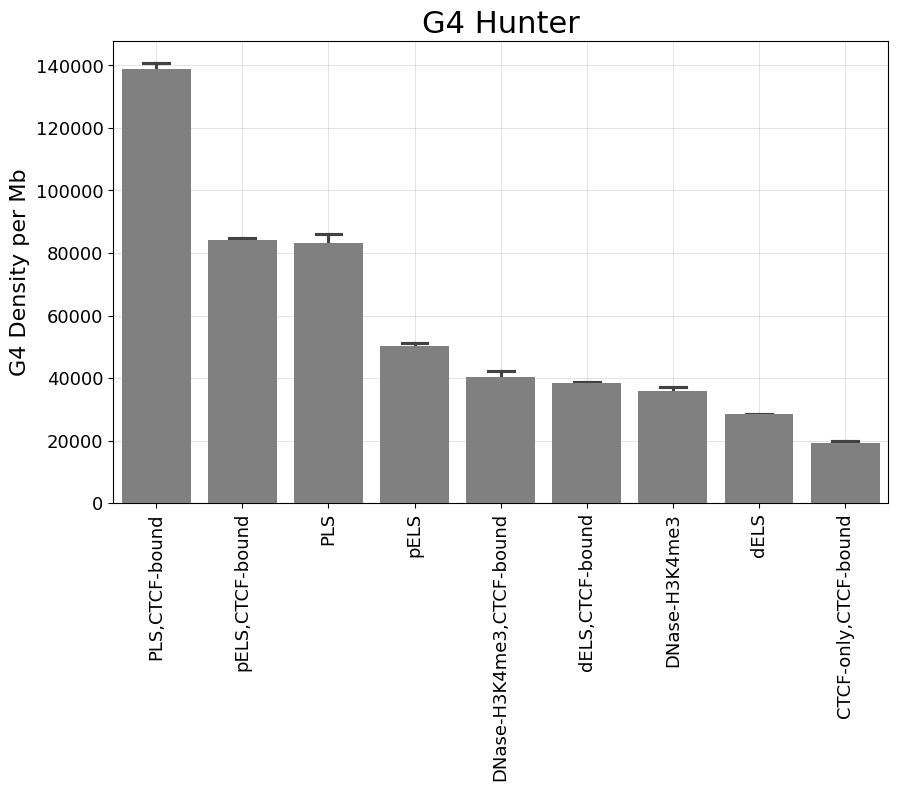

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
sns.barplot(data=coverage_df, 
            color='gray', 
            zorder=3, 
            x="regulatory_element", 
            order=list(coverage_df\
                        .group_by("regulatory_element")\
                        .agg(pl.col("coverage").mean())\
                        .sort(by=['coverage'], descending=True)["regulatory_element"]),
            ax=ax, 
            capsize=.3,
            y="coverage")
ax.grid(lw=0.4, alpha=0.6)
ax.set_axisbelow(True)
ax.set_xlabel("")
ax.tick_params(axis="both", labelsize=13)
ax.tick_params(axis="x", rotation=90)
ax.set_ylabel("G4 Density per Mb")
ax.yaxis.label.set_size(16)
ax.set_title("G4 Hunter")
ax.title.set_size(22)
fig.savefig('cis_regulatory_data/cis_regelements_g4hunter_homo_sapiens.png', bbox_inches='tight')

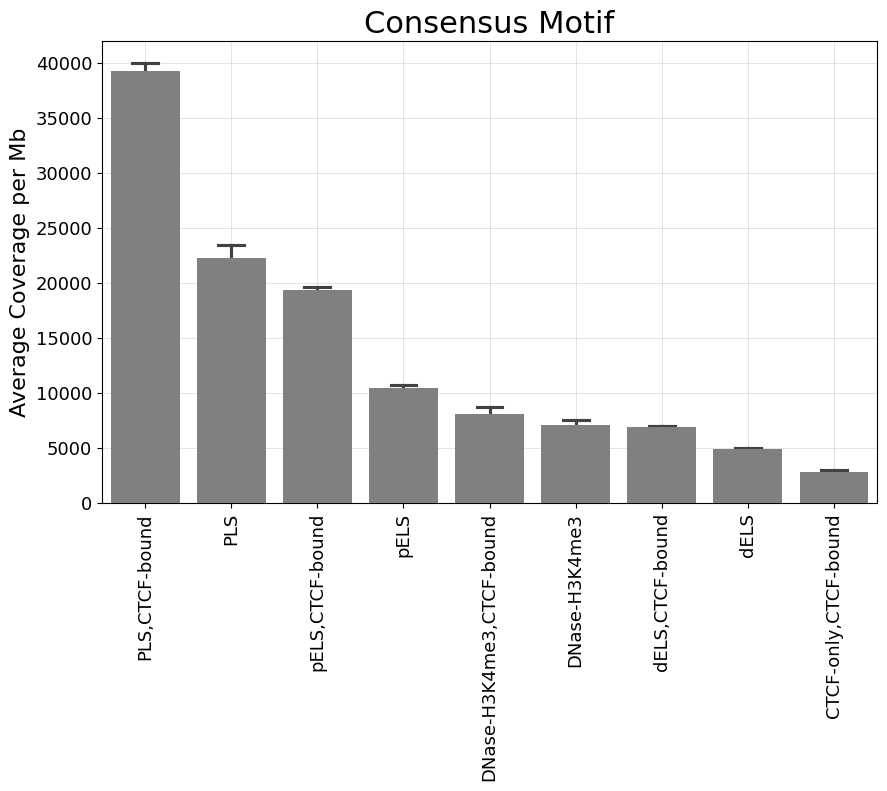

In [52]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
sns.barplot(data=coverage_df_chm13v2_regex, 
            color='gray', 
            zorder=3, 
            x="element", 
            order=coverage_df_chm13v2_regex\
                        .groupby("element")\
                        .agg({"coverage": "mean"})['coverage']\
                        .sort_values(ascending=False)\
                        .index\
                        .tolist(),
            ax=ax, 
            capsize=.3,
            y="coverage")
ax.grid(lw=0.4, alpha=0.6)
ax.set_axisbelow(True)
ax.set_xlabel("")
ax.tick_params(axis="both", labelsize=13)
ax.tick_params(axis="x", rotation=90)
ax.set_ylabel("Average Coverage per Mb")
ax.yaxis.label.set_size(16)
ax.set_title("Consensus Motif")
ax.title.set_size(22)
fig.savefig('elements_regex_homo_sapiens.png', bbox_inches='tight')

## Mus musculus Analysis (mm10)

In [56]:
!ls cis_regulatory_data

GRch38_g4hunter.txt		   mm10_g4hunter.txt.gz
mm10-cCREs.bed			   mm10_regex_motifs.txt
mm10_g4hunter_g4.closest_gene.txt  mm10_regex_motifs.txt.gz
mm10_g4hunter.txt


In [58]:
df_mouse_elements = pl.read_csv("cis_regulatory_data/mm10-cCREs.bed", 
                                    separator="\t",
                                  has_header=False,
                                  columns=[0, 1, 2, 5],
                                  new_columns=["seqID", "start", "end", "regulatory_element"])
df_mouse_elements

seqID,start,end,regulatory_element
str,i64,i64,str
"""chr1""",3012681,3012836,"""CTCF-only,CTCF-bound"""
"""chr1""",3119617,3119911,"""dELS"""
"""chr1""",3119914,3120119,"""dELS"""
"""chr1""",3120346,3120662,"""dELS"""
"""chr1""",3445885,3446198,"""pELS"""
…,…,…,…
"""chrX""",166516781,166517123,"""dELS"""
"""chrX""",166539724,166540065,"""dELS"""
"""chrX""",166895215,166895561,"""dELS"""


In [59]:
faidx = "mm10.fa.fai"
unique_elements = df_mouse_elements['regulatory_element'].unique()
df_elements = []
print(f"Total unique regulatory elements: {len(unique_elements)}")

for element in tqdm(unique_elements):
    df_sliced = df_mouse_elements.filter(pl.col("regulatory_element") == element)
    df_bed = (
                BedTool.from_dataframe(df_sliced.select(["seqID", "start", "end"]).to_pandas())
                .sort(faidx=faidx)
                .merge()
            )
    df = pl.read_csv(
            BedTool.from_dataframe(df_sliced.select(["seqID", "start", "end"]).to_pandas())
                .sort(faidx=faidx)
                .merge().fn,
                       has_header=False, 
                       separator="\t",
                       new_columns=["seqID", "start", "end"]
                      )\
            .with_columns(
                    pl.lit(element).alias("regulatory_element")
            )
    df_elements.append(df)

df_elements = pl.concat(df_elements)
df_elements_bed = BedTool.from_dataframe(df_elements.to_pandas()).sort(faidx=faidx)

# load G4Hunter

g4hunter_mm10 =  pl.read_csv("cis_regulatory_data/mm10_g4hunter.txt",
                            separator="\t",
                            columns=range(3)
                            ).to_pandas()
g4hunter_mm10 = BedTool.from_dataframe(g4hunter_mm10).sort(faidx=faidx)
            
coverage_df_mm10 = pl.read_csv(
                    df_elements_bed.coverage(g4hunter_mm10).fn,
                    has_header=False,
                    separator="\t",
                    new_columns=["seqID", "start", "end", "regulatory_element", "totalCounts", "bpOverlap", "compartmentLength", "coverage"]
            ).with_columns(
                        (1e6 * pl.col("coverage")).alias("coverage")
            )

coverage_df_mm10

Total unique regulatory elements: 9


100%|██████████| 9/9 [00:01<00:00,  4.54it/s]


seqID,start,end,regulatory_element,totalCounts,bpOverlap,compartmentLength,coverage
str,i64,i64,str,i64,i64,i64,f64
"""chr1""",3012681,3012836,"""CTCF-only,CTCF-bound""",0,0,155,0.0
"""chr1""",3119617,3119911,"""dELS""",0,0,294,0.0
"""chr1""",3119914,3120119,"""dELS""",0,0,205,0.0
"""chr1""",3120346,3120662,"""dELS""",0,0,316,0.0
"""chr1""",3292622,3292971,"""dELS""",0,0,349,0.0
…,…,…,…,…,…,…,…
"""chrY""",90731415,90731583,"""dELS,CTCF-bound""",0,0,168,0.0
"""chrY""",90732159,90732509,"""dELS,CTCF-bound""",0,0,350,0.0
"""chrY""",90734379,90734726,"""CTCF-only,CTCF-bound""",0,0,347,0.0


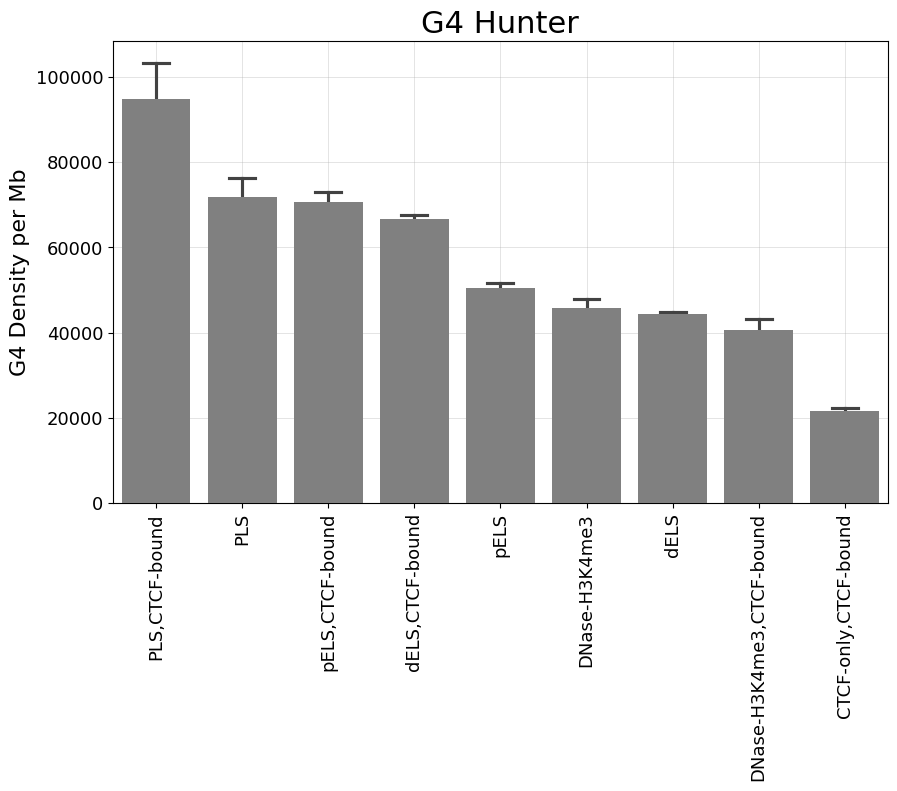

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
sns.barplot(data=coverage_df_mm10, 
            color='gray', 
            zorder=3, 
            x="regulatory_element", 
            order=list(coverage_df_mm10\
                        .group_by("regulatory_element")\
                        .agg(pl.col("coverage").mean())\
                        .sort(by=['coverage'], descending=True)["regulatory_element"]),
            ax=ax, 
            capsize=.3,
            y="coverage")
ax.grid(lw=0.4, alpha=0.6)
ax.set_axisbelow(True)
ax.set_xlabel("")
ax.tick_params(axis="both", labelsize=13)
ax.tick_params(axis="x", rotation=90)
ax.set_ylabel("G4 Density per Mb")
ax.yaxis.label.set_size(16)
ax.set_title("G4 Hunter")
ax.title.set_size(22)
fig.savefig('cis_regulatory_data/cis_regelements_g4hunter_mus_musculus.png', bbox_inches='tight')

In [62]:
# load Regex

g4hunter_mm10_regex =  pl.read_csv("cis_regulatory_data/mm10_regex_motifs.txt",
                            separator="\t",
                            columns=range(3)
                            ).to_pandas()
g4hunter_mm10_regex = BedTool.from_dataframe(g4hunter_mm10_regex).sort(faidx=faidx)
            
coverage_df_mm10_regex = pl.read_csv(
                    df_elements_bed.coverage(g4hunter_mm10_regex).fn,
                    has_header=False,
                    separator="\t",
                    new_columns=["seqID", "start", "end", "regulatory_element", "totalCounts", "bpOverlap", "compartmentLength", "coverage"]
            ).with_columns(
                        (1e6 * pl.col("coverage")).alias("coverage")
            )

coverage_df_mm10_regex

seqID,start,end,regulatory_element,totalCounts,bpOverlap,compartmentLength,coverage
str,i64,i64,str,i64,i64,i64,f64
"""chr1""",3012681,3012836,"""CTCF-only,CTCF-bound""",0,0,155,0.0
"""chr1""",3119617,3119911,"""dELS""",0,0,294,0.0
"""chr1""",3119914,3120119,"""dELS""",0,0,205,0.0
"""chr1""",3120346,3120662,"""dELS""",0,0,316,0.0
"""chr1""",3292622,3292971,"""dELS""",0,0,349,0.0
…,…,…,…,…,…,…,…
"""chrY""",90731415,90731583,"""dELS,CTCF-bound""",0,0,168,0.0
"""chrY""",90732159,90732509,"""dELS,CTCF-bound""",0,0,350,0.0
"""chrY""",90734379,90734726,"""CTCF-only,CTCF-bound""",0,0,347,0.0


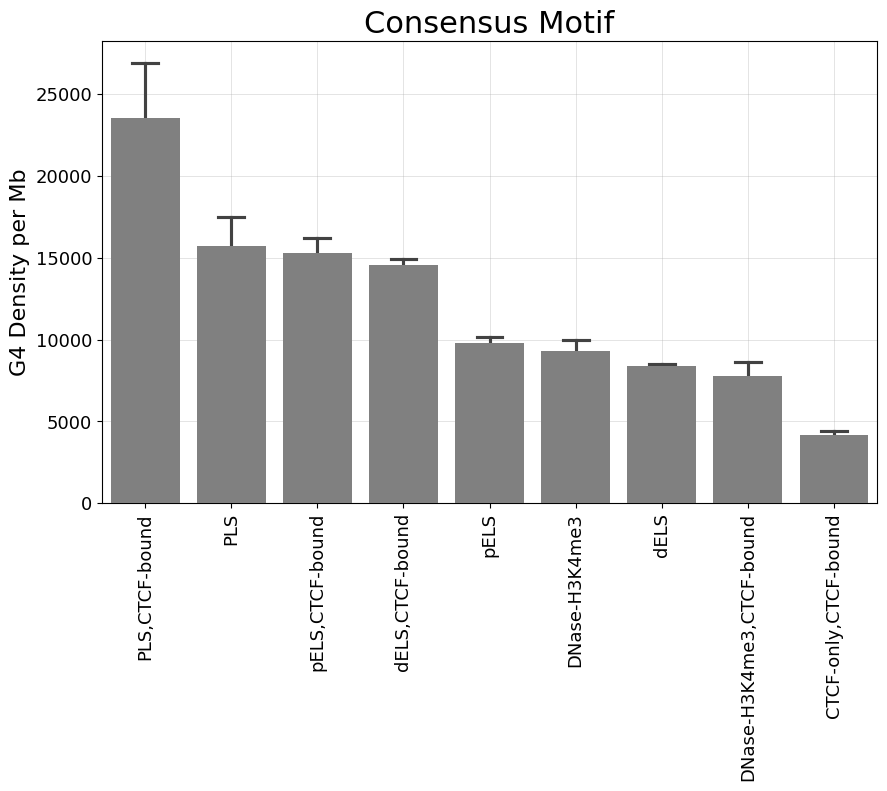

In [69]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
sns.barplot(data=coverage_df_mm10_regex, 
            color='gray', 
            zorder=3, 
            x="regulatory_element", 
            order=list(coverage_df_mm10_regex\
                        .group_by("regulatory_element", maintain_order=True)\
                        .agg(pl.col("coverage").mean())\
                        .sort(by=['coverage'], descending=True)["regulatory_element"]),
            ax=ax, 
            capsize=.3,
            y="coverage")
ax.grid(lw=0.4, alpha=0.6)
ax.set_axisbelow(True)
ax.set_xlabel("")
ax.tick_params(axis="both", labelsize=13)
ax.tick_params(axis="x", rotation=90)
ax.set_ylabel("G4 Density per Mb")
ax.yaxis.label.set_size(16)
ax.set_title("Consensus Motif")
ax.title.set_size(22)
fig.savefig('cis_regulatory_data/cis_regelements_mus_musculus_regex.png', bbox_inches='tight')

In [64]:
coverage_df_chm13v2_regex['atLeastOne'] = (coverage_df_chm13v2_regex['totalCounts'] > 1).astype(int)
print("chm13v2 regex")
print(coverage_df_chm13v2_regex['atLeastOne'].value_counts())

coverage_df_chm13v2_g4hunter['atLeastOne'] = (coverage_df_chm13v2_g4hunter['totalCounts'] > 1).astype(int)
print("chm13v2 g4hunter")
print(coverage_df_chm13v2_g4hunter['atLeastOne'].value_counts())

coverage_df_mouse_regex['atLeastOne'] = (coverage_df_mouse_regex['totalCounts'] > 1).astype(int)
print("Mus musculus regex")
print(coverage_df_mouse_regex['atLeastOne'].value_counts())

coverage_df_mouse_g4hunter['atLeastOne'] = (coverage_df_mouse_g4hunter['totalCounts'] > 1).astype(int)
print("Mus musculus g4hunter")
print(coverage_df_mouse_g4hunter['atLeastOne'].value_counts())

chm13v2 regex
atLeastOne
0    1044839
1      14017
Name: count, dtype: int64
chm13v2 g4hunter
atLeastOne
0    938613
1    120243
Name: count, dtype: int64
Mus musculus regex
atLeastOne
0    362794
1      4875
Name: count, dtype: int64
Mus musculus g4hunter
atLeastOne
0    322464
1     45205
Name: count, dtype: int64
